# Doodling in Hardware

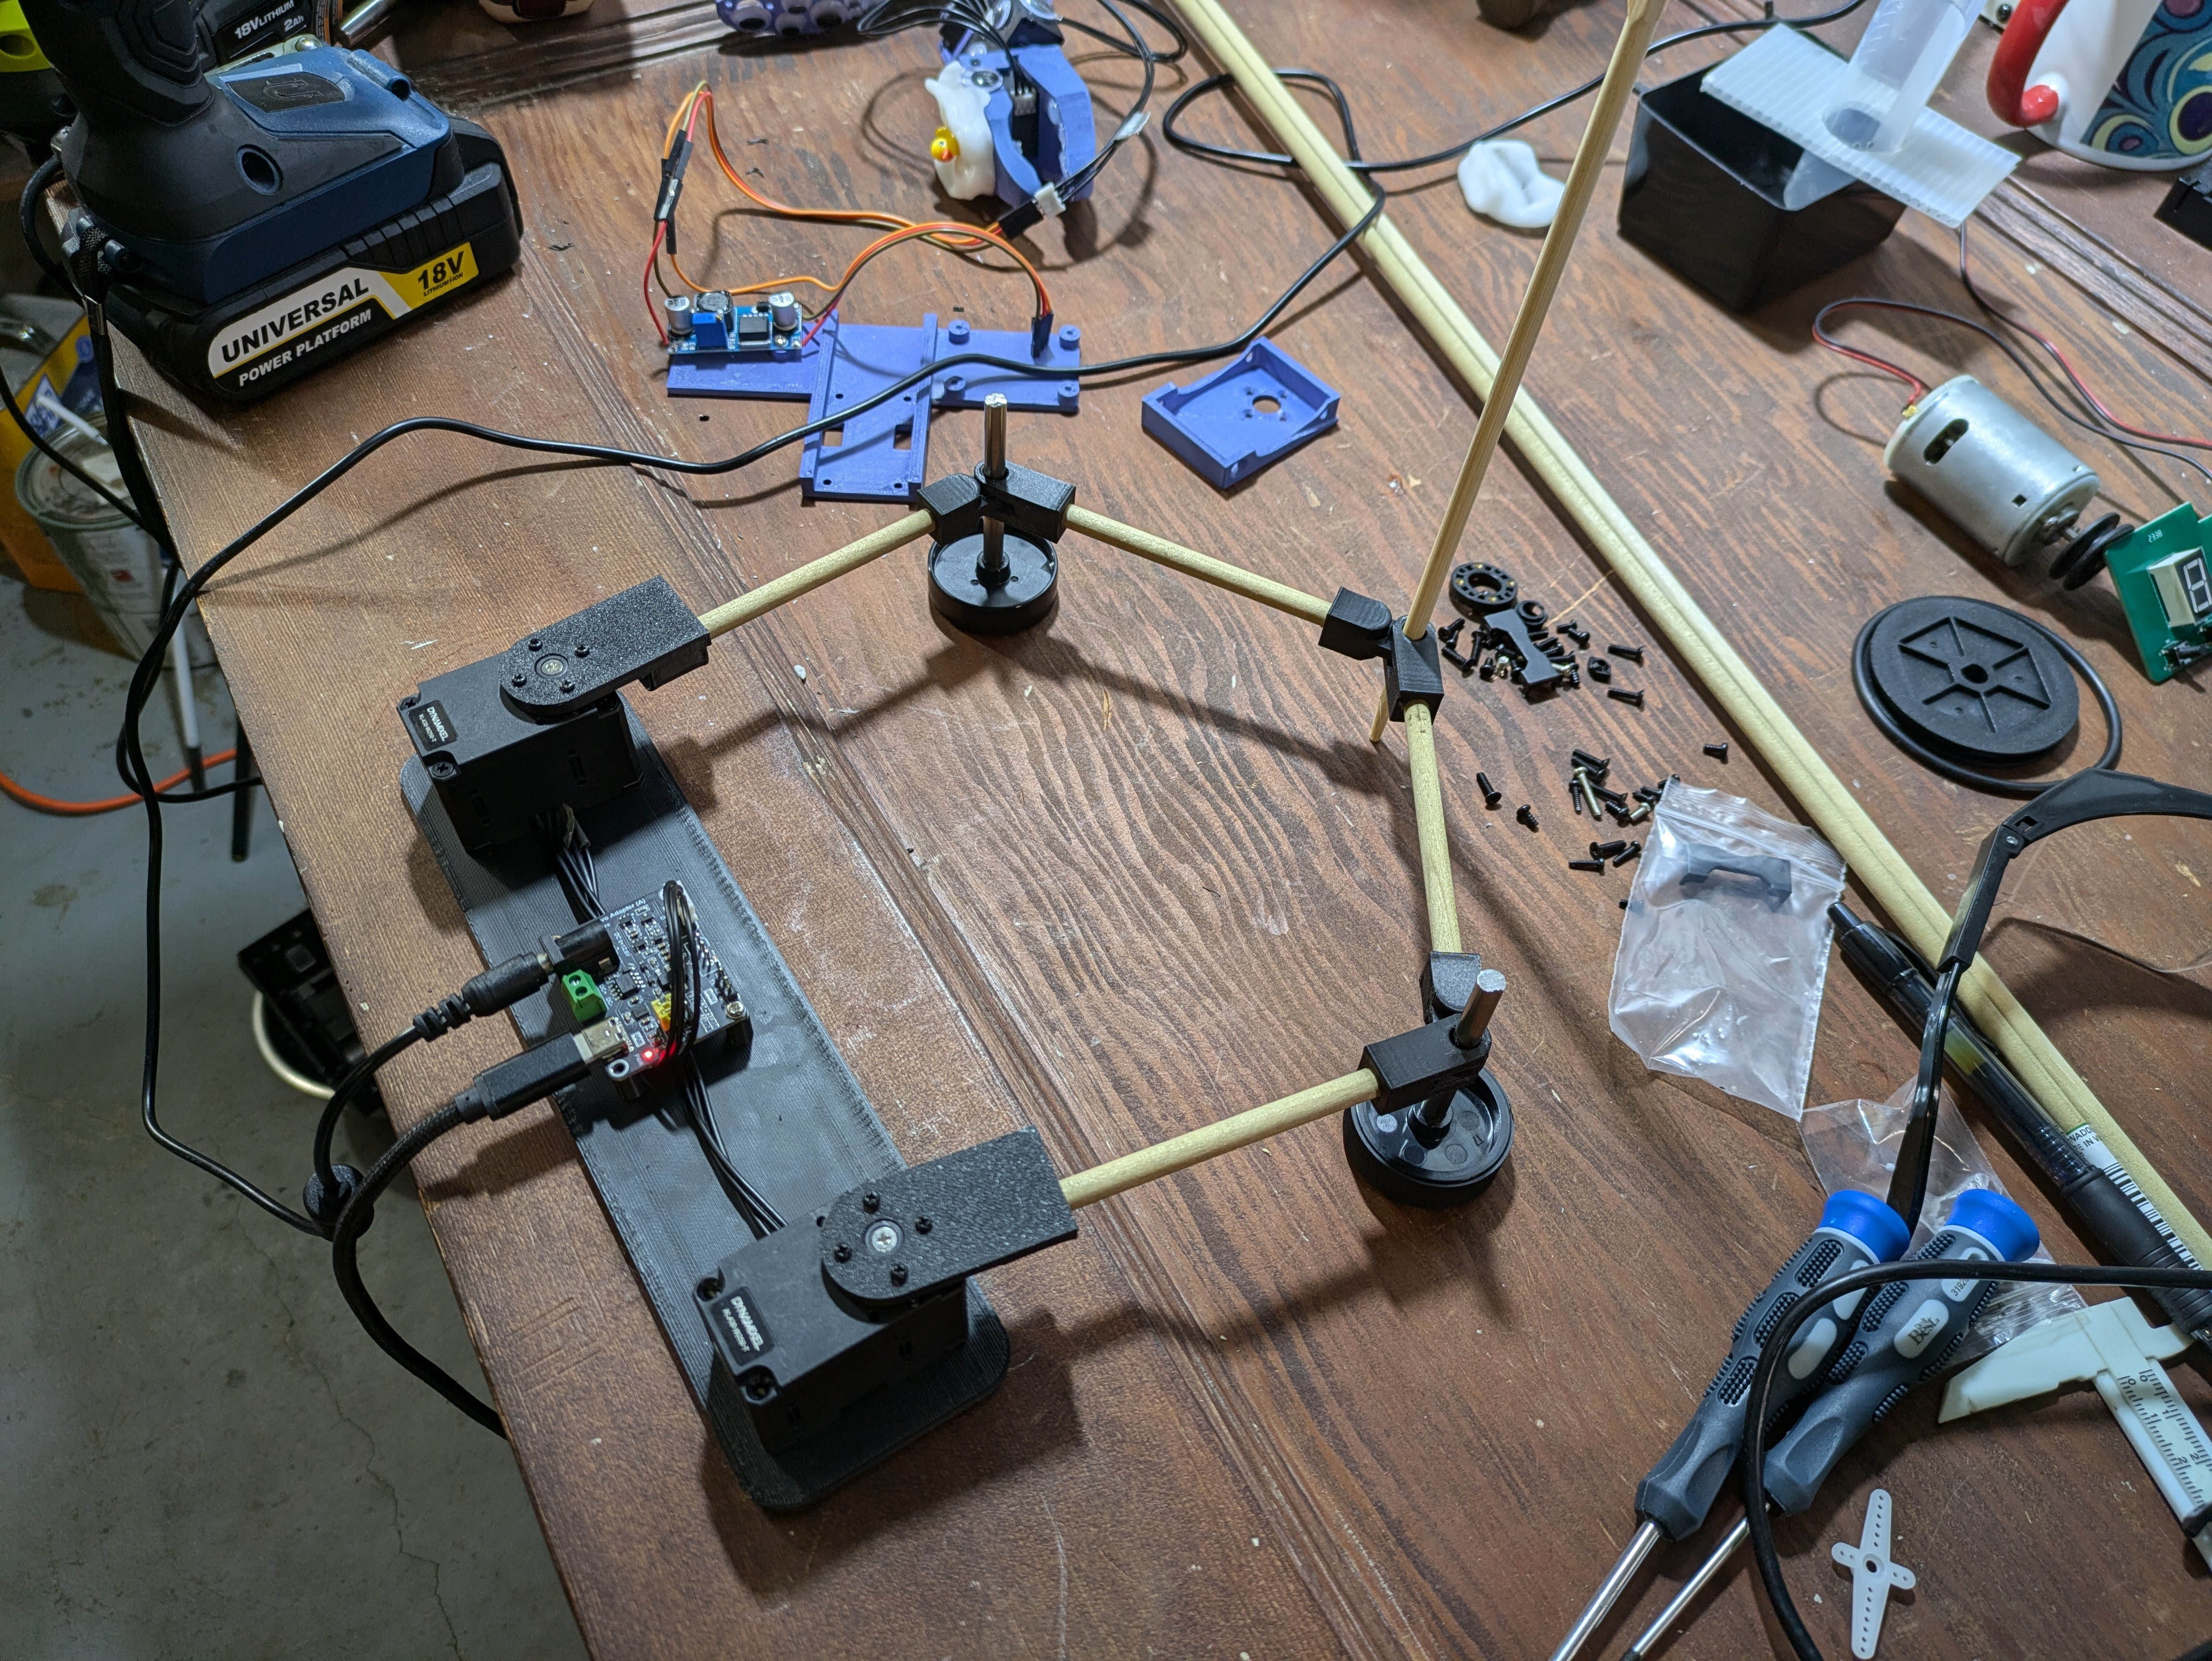

I wanted to do *something* physical. Maybe a motion system that's not just another cartesian X/Y thing? Something I can test out Kalman filters and control systems on? Something that could move a magnet to pull a ball bearing around on some sand in that oh-so-satisfying way?

They way this came together is a nice example of one of my favourite ways to make something - which I've started calling 'doodling in hardware'. Once I had a vague idea of what I wanted to make, I drew out some quick sketches, took a few measurements, and set the base printing. Here's the sketch:

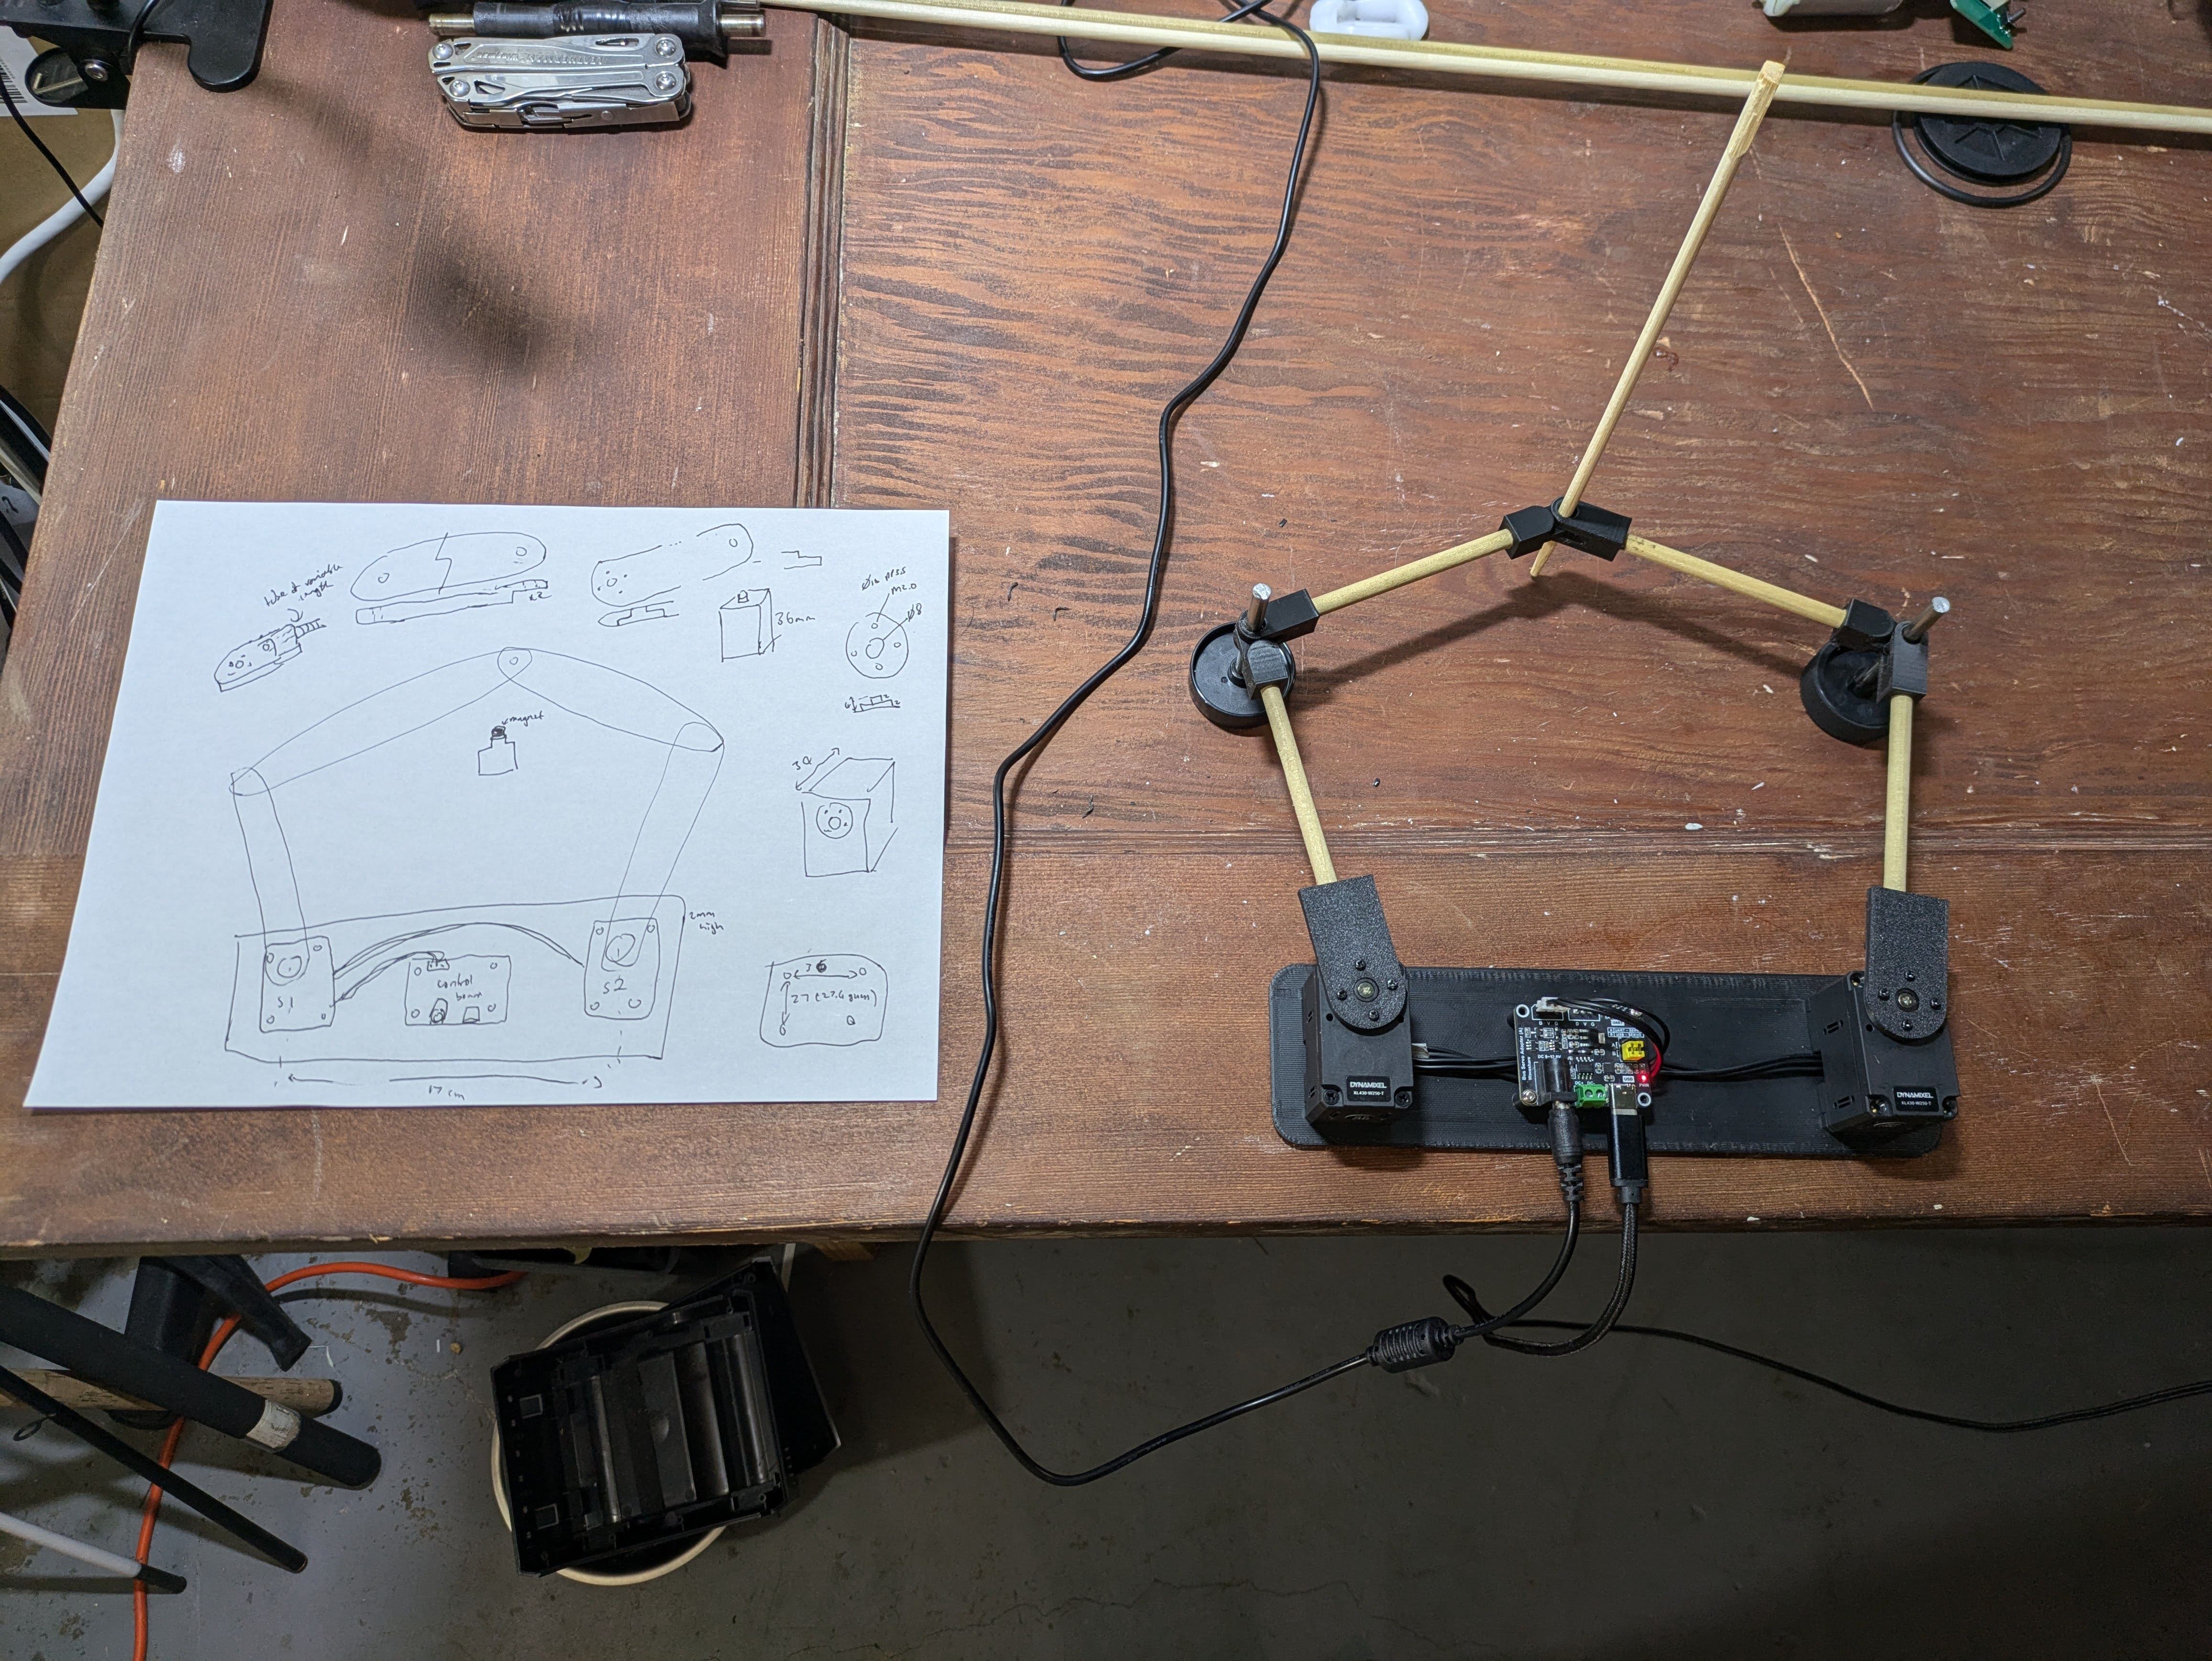

While the base printed I could take apart my robot arm to scavenge the servos and start messing with figuring out how to move to a certain X/Y position given different dimensions of the robot (code explorations at the end of this post). I also designed the holders to fit the servos. 

While the 'servo horns' were printing, I could assemble the circuit on the base, get the motors moving, and design the swivel mechanisms.

While the swivel bits were printing I could walk to the hardware store for 1/4 inch dowels (or maybe I did that earlier?).

You see the trend? These prints take 20-30 minutes (or an hour or so for the base IIRC). Just enough time to tinker with existing things or work on a revision. The upshot is a morning spent in flow, a precious gift. This is the dream! It's not like I have a super-fancy workshop yet but even the baseline here is enough that I'm not hitting blockers that throw the project as much as I used to. My junk bins are growing more bountiful, my tools more capable. 

This particularly project is pretty silly. I spotted some obvious flaws once it was assembled and moving about that will need correcting in a possible V2. But I'm so happy I am in a place I can occasionally tinker with something silly like this and have the process be so smooth and enjoyable :)

OK, now the code as promised. I code all day for my job, so for weekend projects like this the goal is to avoid it as much as possible and have AI do the boring bits.

## Simulating A Scara Arm

**Aside: This is the end result of some prompting across a few different AI's. Starting with ChatGPT 'what's this kind of motion system called again?'.**

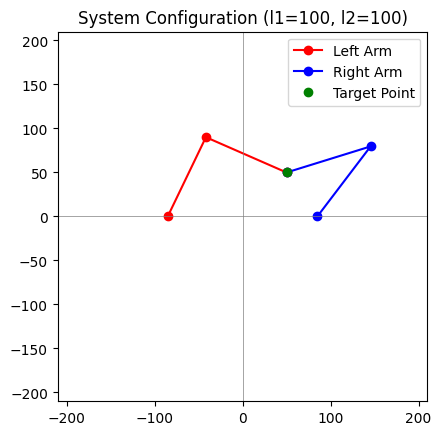

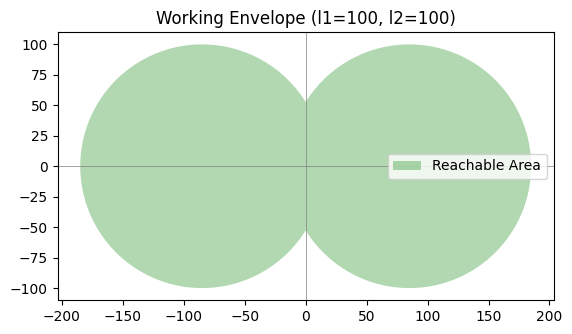

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
d = 170  # Distance between the two servo bases in mm

def inverse_kinematics_arm(x, y, l1, l2, offset, prefer_elbow_up=True):
    # Shift the target point according to the base offset
    x = x - offset

    # Calculate distance from the base to the target point
    D = np.sqrt(x**2 + y**2)

    if D > (l1 + l2):
        raise ValueError("The target point is out of reach for this arm!")

    # Angle for the second section of the arm (elbow joint)
    cos_theta2 = (D**2 - l1**2 - l2**2) / (2 * l1 * l2)
    theta2 = np.arccos(cos_theta2)  # This is the "elbow up" solution

    # Prefer elbow up by default, flip for elbow down if needed
    if not prefer_elbow_up:
        theta2 = -theta2

    # Angle for the first section of the arm (shoulder joint)
    k1 = l1 + l2 * np.cos(theta2)
    k2 = l2 * np.sin(theta2)

    theta1 = np.arctan2(y, x) - np.arctan2(k2, k1)

    return np.degrees(theta1), np.degrees(theta2)


# Forward Kinematics for each arm
def forward_kinematics_arm(theta1, theta2, l1, l2, offset):
    # Convert angles to radians
    theta1 = np.radians(theta1)
    theta2 = np.radians(theta2)

    # Position of the first section's end (relative to the base)
    x1 = offset + l1 * np.cos(theta1)
    y1 = l1 * np.sin(theta1)

    # Position of the second section's end (end-effector position)
    x2 = x1 + l2 * np.cos(theta1 + theta2)
    y2 = y1 + l2 * np.sin(theta1 + theta2)

    return [offset, x1, x2], [0, y1, y2]

# Visualization of the whole system
def visualize_system(x, y, l1, l2, prefer_elbow_up=True):
    # Calculate angles for both arms with elbow preference
    theta1_left, theta2_left = inverse_kinematics_arm(x, y, l1, l2, -d/2, not prefer_elbow_up)
    theta1_right, theta2_right = inverse_kinematics_arm(x, y, l1, l2, d/2, prefer_elbow_up)

    # Get the points for both arms using forward kinematics
    x_points_left, y_points_left = forward_kinematics_arm(theta1_left, theta2_left, l1, l2, -d/2)
    x_points_right, y_points_right = forward_kinematics_arm(theta1_right, theta2_right, l1, l2, d/2)

    # Plot both arms
    plt.plot(x_points_left, y_points_left, 'ro-', label='Left Arm')
    plt.plot(x_points_right, y_points_right, 'bo-', label='Right Arm')
    plt.plot([x], [y], 'go', label='Target Point')
    plt.xlim(-l1-l2-10, l1+l2+10)
    plt.ylim(-l1-l2-10, l1+l2+10)
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.title(f'System Configuration (l1={l1}, l2={l2})')
    plt.show()


# Working Envelope for two arms
def plot_working_envelope(l1, l2):
    theta_range = np.linspace(0, 2*np.pi, 100)

    # Envelope for the left arm
    x_reach_left = l1 * np.cos(theta_range) + (-d/2)
    y_reach_left = l1 * np.sin(theta_range)

    # Envelope for the right arm
    x_reach_right = l1 * np.cos(theta_range) + (d/2)
    y_reach_right = l1 * np.sin(theta_range)

    plt.fill(np.concatenate([x_reach_left, x_reach_right]),
             np.concatenate([y_reach_left, y_reach_right]), 'green', alpha=0.3, label='Reachable Area')

    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'Working Envelope (l1={l1}, l2={l2})')
    plt.legend()
    plt.show()

# Example usage
l1, l2 = 100, 100  # Length of the arm sections
x, y = 50, 50      # Target position

# Visualize the system
visualize_system(x, y, l1, l2)

# Plot the working envelope
plot_working_envelope(l1, l2)


In [4]:
# prompt: Make a widget with sliders for l1, l2, x and y that shows the system as these values change

import ipywidgets as widgets
from IPython.display import display

def update_system(l1, l2, x, y):
    try:
        visualize_system(x, y, l1, l2)
    except ValueError as e:
        print(e)

l1_slider = widgets.IntSlider(value=100, min=50, max=200, description='l1:')
l2_slider = widgets.IntSlider(value=100, min=50, max=200, description='l2:')
x_slider = widgets.IntSlider(value=50, min=-200, max=200, description='x:')
y_slider = widgets.IntSlider(value=50, min=-200, max=200, description='y:')

widgets.interactive(update_system, l1=l1_slider, l2=l2_slider, x=x_slider, y=y_slider)

interactive(children=(IntSlider(value=100, description='l1:', max=200, min=50), IntSlider(value=100, descripti…

PS: Not sure I trust the working area visualization, but that's partly because there are often two unique positions the end could be in for many sets of base angles!